# Sparse Bottleneck Networks for Exploratory Analysis and Visualization of Neural Patch-seq Data

In [23]:
# Import packages
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib
import seaborn as sns
import sparseRRR
import matplotlib
import matplotlib.pyplot as plt
import importlib

import bottleneck_networks

import time
import pickle
import warnings

dtype = tf.float32

def sns_styleset():
    sns.set_style('ticks', {'axes.linewidth': .75, "xtick.major.size":4, "ytick.major.size":4})

# Loading data

In [24]:
gouwens = pickle.load(open('data/gouwens_2020/gouwens2020.pickle', 'rb'))
genes=gouwens['X']
ephys=gouwens['Y']
gene_names=gouwens['gene_names']
cell_types=gouwens['celltypes']
cell_id_to_cell_type=gouwens['map']
ephys_names=gouwens['ephys_features']
colors=gouwens['colors']

Let us find K-mean clusters to perform pre-training. One could also pre-train on celltype classification. This has actually improved performance even more but could be argued to be biasing the results too much. K-means allows for an unsupervised more general setting.

In [26]:
# You can cluster according to amounts of classes or amounts of celltypes. Change the argument of n_clusters accordingly.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=17, n_init=1000).fit(ephys)

In [27]:
clusters = kmeans.labels_

In [28]:
amount_of_cells_in_clusters = {cluster_id: sum(clusters==cluster_id) for cluster_id in np.unique(clusters)}
for_every_cell_number_of_cells_of_their_cluster = np.array([amount_of_cells_in_clusters[cell] for cell in clusters])
ind_pre_training_clusters = for_every_cell_number_of_cells_of_their_cluster >= 10

# Keras initialisations

In [29]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import metrics
from tensorflow.keras.losses import CategoricalCrossentropy

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

In [31]:
# You should assume you get two TensorFlow variables as input
y_actual = tf.placeholder(dtype = tf.float32)
y_predicted = tf.placeholder(dtype = tf.float32)
def r2_score(y_truth, y_pred):
    residual = tf.add(y_truth, -y_pred, name='residual')
    return 1-tf.reduce_sum(tf.square(residual)) / tf.reduce_sum(tf.square(y_truth))
r2_score_result = r2_score(y_actual, y_predicted)

In [32]:
class ElasticNet(tf.keras.regularizers.Regularizer): 
    def __init__(self, l1=1e-8, l2=1.0): 
        self.l1 = l1
        self.l2 = l2

    def __call__(self, x): 
        return self.l2*tf.math.reduce_sum(tf.math.square(x)) + \
                             self.l1*tf.reduce_sum(tf.norm(x, ord = 2, axis = 1))

    def get_config(self): 
        return {'l1': float(self.l1), 'l2': float(self.l2)}

# Ridge only, test different models w.r.t. reduced-rank-regression

Running all the following models can take up time (~10minutes). One can also simpy load the trained models in the following section. You can jump right into the group lasso + ridge setting in the next section.

Our ridge penalty only straight regression (no pre-training) model.

In [12]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/sBNN/bottleneck_networks.py'>

In [62]:
ephys.shape

(3395, 55)

In [63]:
genes.shape

(3395, 1252)

In [13]:
from bottleneck_networks import StraightRegression

In [14]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
MSE_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
MSE_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
train_ephys = []
test_ephys = []
train_ephys_predict = []
test_ephys_predict = []

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]


# CV folds
for cvfold in range(folds):
    print('CVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    train_ephys.append(y_train)
    test_ephys.append(y_test)
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim)
            train_ephys_pred, test_ephys_pred, \
                r2_train, r2_test, train_hist, test_hist, \
                MSE_tr, MSE_test = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   verbose=0)
            train_ephys_predict.append(train_ephys_pred)
            test_ephys_predict.append(test_ephys_pred)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            MSE_hist[cvfold, j, i] = MSE_test
            MSE_hist_tr[cvfold, j, i] = MSE_tr
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

CVFOLD:  0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
[INFO] training network...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train R^2:  0.2954866290092468
Test R^2:  0.27036017179489136
CVFOLD:  1
[INFO] training network...
Train R^2:  0.28641408681869507
Test R^2:  0.2510087490081787
CVFOLD:  2
[INFO] training network...
Train R^2:  0.2970789074897766
Test R^2:  0.24351531267166138
CVFOLD:  3
[INFO] training network...
Train R^2:  0.3040401339530945
Test R^2:  0.2525940537452698
CVFOLD:  4
[INFO] training network...
Train R^2:  0.3052824139595032
Test R^2:  0.21607059240341187
CVFOLD:  5
[INFO] training network...
Train R^2:  0.295149028301239
Test R^2:  0.24529969692230225
CVFOLD:  6
[INFO] training network...
Train R^2:  0.3212377429008484
Test R^2:  0.257

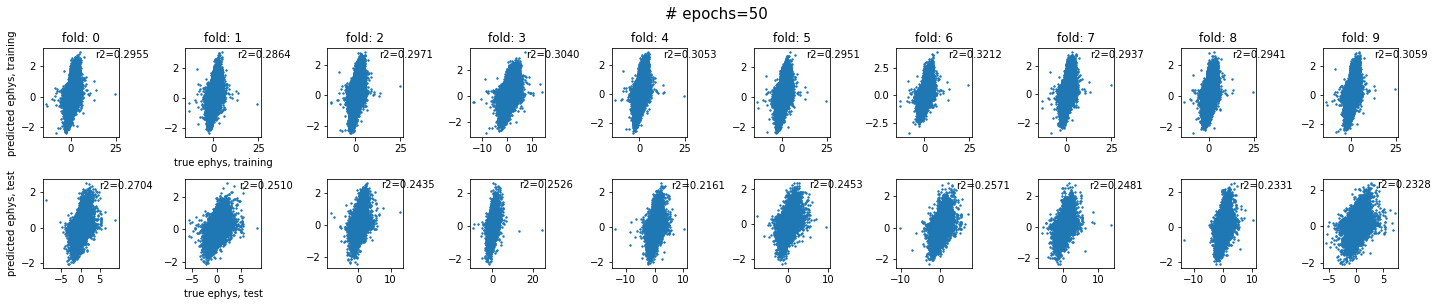

In [15]:
# First visualisation of the data.
fig, axes = plt.subplots(2, folds, figsize=(2*folds, 4))
for i in range(folds):
    axes[0, i].scatter(train_ephys[i], train_ephys_predict[i], s=2)
    axes[0, i].annotate('r2={:.4f}'.format(r2_straight_regr_tr[i, 0, 0]), \
                    xy=(0.5*axes[0, i].get_xlim()[1], 0.8*axes[0, i].get_ylim()[1]))
    axes[0, i].set_title('fold: {}'.format(i))
    axes[1, i].scatter(test_ephys[i], test_ephys_predict[i], s=2)
    axes[1, i].annotate('r2={:.4f}'.format(r2_straight_regr[i, 0, 0]), \
                    xy=(0.5*axes[1, i].get_xlim()[1], 0.8*axes[1, i].get_ylim()[1]))
axes[0, 1].set_xlabel('true ephys, training')
axes[0, 0].set_ylabel('predicted ephys, training')
axes[1, 1].set_xlabel('true ephys, test')
axes[1, 0].set_ylabel('predicted ephys, test')
fig.suptitle('# epochs={}'.format(epochs), fontsize=15, y=1.05)
plt.tight_layout()

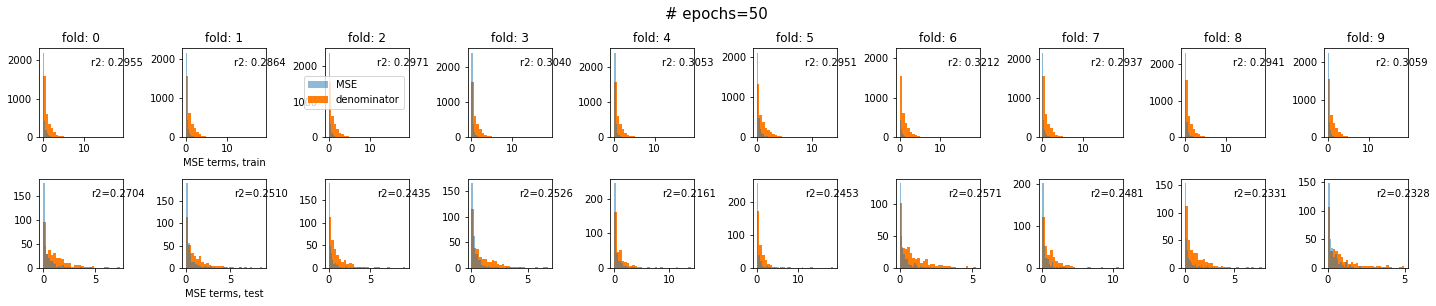

In [16]:
fig, axes = plt.subplots(2, folds, figsize=(2*folds, 4))
for i in range(folds):
    axes[0, i].hist((train_ephys[i]-train_ephys_predict[i])[:, 0]**2, bins=30, alpha=0.5, zorder=1, label='MSE')
    axes[0, i].hist(train_ephys[i][:, 0]**2, bins=30, zorder=0, label='denominator')
    axes[0, i].annotate('r2: {:.4f}'.format(r2_straight_regr_tr[i, 0, 0]), \
                        xy=(0.6*axes[0, i].get_xlim()[1], 0.8*axes[0, i].get_ylim()[1]))
    axes[0, i].set_title('fold: {}'.format(i))
    axes[1, i].hist((test_ephys[i]-test_ephys_predict[i])[:, 0]**2, bins=30, alpha=0.5, zorder=1, label='MSE')
    axes[1, i].hist(test_ephys[i][:, 0]**2, bins=30, zorder=0, label='denominator')
    axes[1, i].annotate('r2={:.4f}'.format(r2_straight_regr[i, 0, 0]), \
                        xy=(0.6*axes[1, i].get_xlim()[1], 0.8*axes[1, i].get_ylim()[1]))
fig.suptitle('# epochs={}'.format(epochs), fontsize=15, y=1.05)
axes[0, 2].legend(loc='right')
axes[0, 1].set_xlabel('MSE terms, train')
axes[1, 1].set_xlabel('MSE terms, test')
plt.tight_layout()

In [17]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_straight_regr.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Our ridge penalty only classification pre-training model.

In [18]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/sBNN/bottleneck_networks.py'>

In [19]:
from bottleneck_networks import ClassificationPreTrain

In [20]:
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act='elu'
folds=10
seed=42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be done with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
1222/1222 [==============================] - 0s 84us/sample - loss: 1.8845 - categorical_crossentropy: 1.8845

CVFOLD:  1
[INFO] training network...
1222/1222 [==============================] - 0s 71us/sample - loss: 1.8587 - categorical_crossentropy: 1.8587

CVFOLD:  2
[INFO] training network...
1222/1222 [==============================] - 0s 79us/sample - loss: 1.9062 - categorical_crossentropy: 1.9062

CVFOLD:  3
[INFO] training network...
1222/1222 [==============================] - 0s 80us/sample - loss: 1.8693 - categorical_crossentropy: 1.8693

CVFOLD:  4
[INFO] training network...
1222/1222 [==============================] - 0s 78us/sample - loss: 1.9046 - categorical_crossentropy: 1.9046

CVFOLD:  5
[INFO] training network...
1222/1222 [==============================] - 0s 70us/sample - loss: 1.9914 - categorical_crossentropy: 1.9914

CVFOLD:  6
[INFO] training network...
1222/1222 [==============================] - 0s 85us/sample - loss:

In [21]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_pre_tr.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Our ridge penalty only pre-train and regression model.

In [22]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5)
            _, _, r2_train, r2_test, train_hist, test_hist, _, _ = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
Train R^2:  0.29537564516067505
Test R^2:  0.2737046480178833

CVFOLD:  1
[INFO] training network...
Train R^2:  0.31493324041366577
Test R^2:  0.25129204988479614

CVFOLD:  2
[INFO] training network...
Train R^2:  0.29706627130508423
Test R^2:  0.2468230128288269

CVFOLD:  3
[INFO] training network...
Train R^2:  0.29729336500167847
Test R^2:  0.25333869457244873

CVFOLD:  4
[INFO] training network...
Train R^2:  0.31884485483169556
Test R^2:  0.2313109040260315

CVFOLD:  5
[INFO] training network...
Train R^2:  0.2908056378364563
Test R^2:  0.230515718460083

CVFOLD:  6
[INFO] training network...
Train R^2:  0.29499512910842896
Test R^2:  0.25751954317092896

CVFOLD:  7
[INFO] training network...
Train R^2:  0.3257659077644348
Test R^2:  0.2561138868331909

CVFOLD:  8
[INFO] training network...
Train R^2:  0.28797173500061035
Test R^2:  0.23909300565719604

CVFOLD:  9
[INFO] training network...
Train R^2:  0.3132207989692688
Test R^2:  0.2267537

In [23]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_straight_regr.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Our ridge penalty only pre-train + freeze the first 2 layers + unfreeze model.

In [24]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/sBNN/bottleneck_networks.py'>

In [25]:
from bottleneck_networks import FreezeUnfreeze

In [26]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([0])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first


r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 2*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 2*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    verbose=0)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.27260851860046387
Test R^2 before unfreezing:  0.2804098129272461
Train R^2 after unfreezing:  0.3173149824142456
Test R^2 after unfreezing:  0.2950966954231262

CVFOLD:  1
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.2796868681907654
Test R^2 before unfreezing:  0.2676529288291931
Train R^2 after unfreezing:  0.32301580905914307
Test R^2 after unfreezing:  0.2811216711997986

CVFOLD:  2
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.2679446339607239
Test R^2 before unfreezing:  0.24846845865249634
Train R^2 after unfreezing:  0.3045540452003479
Test R^2 after unfreezing:  0.2655577063560486

CVFOLD:  3
[INFO] training network...
[INFO] training network...
Train R^2 before unfreezing:  0.27461379766464233
Test R^2 before unfreezing:  0.2593858242034912
Train R^2 after unfreezing:  0.32986927032470703
Test R^2 a

In [27]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In the next section we perform reduced-rank regression cross validation (rank = 2 and full rank).

In [28]:
# CV sRRR rank = 2

lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,8)])
alphas = np.array([0])

rank = 2
folds = 10
seed = 42

r2_sRRR_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))

# Uncomment if one lambda only
train_ephys = []
test_ephys = []
train_ephys_predict = []
test_ephys_predict = []

t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    train_ephys.append(y_train)
    test_ephys.append(y_test)
    for i,a in enumerate(lambdas):
        #print('Lambdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            nonzero_rank2[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_relaxed_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_relaxed_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            
            train_ephys_predict.append(x_train@vx@vy.T)
            test_ephys_predict.append(x_test@vx@vy.T)
            #print(r2_sRRR_relaxed_rank2[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h 10m 56s


In [29]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank2_CV.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2], f)

In [30]:
# CV sRRR rank=16

lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,8)])
alphas = np.array([0])

rank = 16
folds = 10
seed = 42

r2_sRRR_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Labmdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            nonzero_rank16[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum((y_test-np.mean(y_test))**2)
            r2_sRRR_relaxed_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum((y_train-np.mean(y_train, axis=0))**2)
            for r in range(rank):
                corrs_relaxed_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank16_tr[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h 10m 55s


In [31]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank16_CV.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16], f)

We now have cross validated results for all the ridge penalty models we care about. Let us now analyse and compare the training curves. 

In [32]:
lambdas = np.concatenate([np.arange(.1,2,.1), np.arange(2,10)])

In [33]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank2_CV.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [34]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank16_CV.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [35]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_pre_tr.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [36]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_straight_regr.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [37]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_straight_regr.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [38]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [39]:
np.max(np.mean(r2_sRRR_relaxed_rank2, axis=0))

0.20557825748452796

In [40]:
np.max(np.mean(r2_sRRR_relaxed_rank16, axis=0))

0.3283334237414588

In [41]:
np.mean(r2_straight_regr)

0.24499034881591797

In [42]:
np.mean(r2_pretr_straight_regr)

0.2466465175151825

In [43]:
np.mean(r2_before_unfreezing)

0.25846431255340574

In [44]:
np.mean(r2_after_unfreezing)

0.27177627086639405

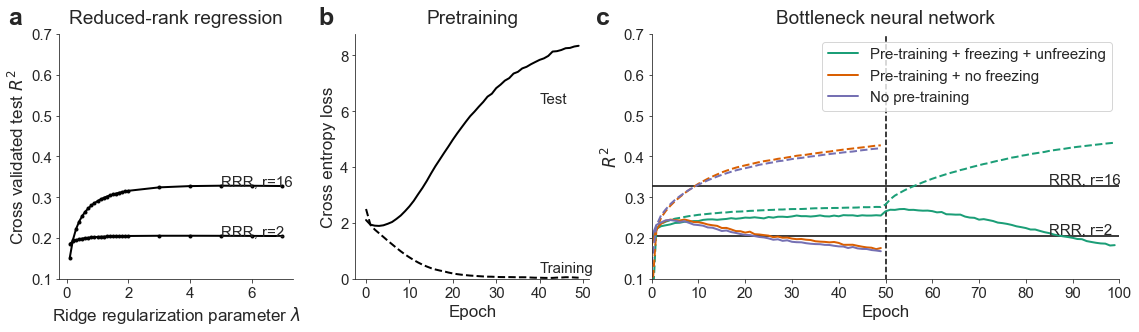

In [46]:
linewidth = 2
sns_styleset()

r2_sRRR_relaxed_rank2[r2_sRRR_relaxed_rank2==0]=np.nan
r2_sRRR_relaxed_rank2_ =  np.nanmean(r2_sRRR_relaxed_rank2, axis = 0)
r2_sRRR_relaxed_rank16[r2_sRRR_relaxed_rank16==0]=np.nan
r2_sRRR_relaxed_rank16_ =  np.nanmean(r2_sRRR_relaxed_rank16, axis = 0)


# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], \
             r2_sRRR_relaxed_rank16_[0, :][np.nonzero(r2_sRRR_relaxed_rank16_[0, :])], '.-', \
             c = np.array([0, 0, 0]) / 256, linewidth = linewidth, \
             label = 'r=16')
ax1.plot(lambdas[np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], \
             r2_sRRR_relaxed_rank2_[0, :][np.nonzero(r2_sRRR_relaxed_rank2_[0, :])], '.-', \
             c = np.array([0, 0, 0])/256, linewidth = linewidth, \
             label = 'r=2')
ax1.annotate('RRR, r=16', (5, np.max(r2_sRRR_relaxed_rank16_)+0.0002), fontsize=15)
ax1.annotate('RRR, r=2', (5, np.max(r2_sRRR_relaxed_rank2_)+0.0002), fontsize=15)
ax1.set_xlabel(r'Ridge regularization parameter $\lambda$', fontsize = 17)
ax1.set_ylabel(r'Cross validated test $R^2$', fontsize = 17)
ax1.set_title('Reduced-rank regression', fontsize = 19, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.set_ylim([0.1,0.7])

ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 1, 2)), \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 1, 2)), \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([0, ax2.get_ylim()[1]])
ax2.annotate('Training', (40, 0.22), fontsize=15)
ax2.annotate('Test', (40, 6.3), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(100), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(100), np.mean(r2_freeze_unfreeze_hist, axis=(0, 1, 2)), \
         c = '#1b9e77', linewidth=linewidth, label='Pre-training + freezing + unfreezing')
ax3.plot(range(50), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(50), np.mean(r2_pretr_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(50), np.mean(r2_straight_regr_hist_tr, axis=(0, 1, 2)), \
         '--', c = '#7570b3', linewidth=linewidth)
ax3.plot(range(50), np.mean(r2_straight_regr_hist, axis=(0, 1, 2)), \
         c = '#7570b3', linewidth=linewidth, label='No pre-training')
ax3.hlines(np.max(r2_sRRR_relaxed_rank2_), xmin = 0, xmax = 120, \
            colors = np.array([0,0,0])/256)
ax3.annotate('RRR, r=2', (85, np.max(r2_sRRR_relaxed_rank2_)+0.005), fontsize=15)
ax3.hlines(np.max(r2_sRRR_relaxed_rank16_), xmin = 0, xmax = 120, \
           colors = np.array([0,0,0])/256)
ax3.annotate('RRR, r=16', (85, np.max(r2_sRRR_relaxed_rank16_)+0.005), fontsize=15)
ax3.legend(loc = 'upper right', fontsize=15)
ax3.set_ylim([0.1,0.7])
ax3.set_xlim([0,100])
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.set_xticks(np.arange(0, 110, 10))
ax3.vlines(50, ymin=0, ymax=ax3.get_ylim()[1], linestyle='dashed')

plt.text(-0.22, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.16, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.12, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()
plt.savefig('figures/Allen_Ridge_training_curves.pdf', bbox_inches = 'tight',
    pad_inches = 0)
plt.savefig('figures/Allen_Ridge_training_curves.png', bbox_inches = 'tight',
    pad_inches = 0)

# Add lasso

It seems that pre-train - train 4 last layers - train all layers is a good bottleneck non-linear model. Let us add a lasso group penalty now and investigate which genes the model would select. After the usual training as above we also prune the bottleneck further. In essence we pick the 25 genes that correspond to highest L2 row norm for the first kernel/weight of the input layer and perform the same regression task but with this reduced new 25 nodes input layer. No lasso, just ridge for this pruned network. We investigate which genes are selected, visualise the latent space and compare to a well-known sparse reduced-rank model for this dataset. Again, one can skip the training and go direct to visualization for already trained models.

Our ridge + lasso penalty straight regression (no pre-training) model.

In [33]:
importlib.reload(bottleneck_networks)

<module 'bottleneck_networks' from '/gpfs01/berens/user/ybernaerts/EphysAnalysis/data/ephys/sBNN/bottleneck_networks.py'>

In [34]:
from bottleneck_networks import StraightRegression

In [35]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
prune=True
patience=epochs

r2_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            BN_StraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                                       input_dim=input_dim, output_dim=output_dim, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_ap_train, r2_ap_test, \
                train_hist, test_hist = BN_StraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_straight_regr[cvfold, j, i] = r2_test
            r2_straight_regr_tr[cvfold, j, i] = r2_train
            r2_straight_regr_ap[cvfold, j, i] = r2_ap_test
            r2_straight_regr_ap_tr[cvfold, j, i] = r2_ap_train
            r2_straight_regr_hist[cvfold, j, i] = test_hist
            r2_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (straight regression, no pre-tr): ', r2_straight_regr[cvfold, j, i])
            #print('Test R^2 score after pruning (straight regression, no pre-tr): ', r2_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
The 25 genes that make it:  ['Zfpm2' 'Cdh12' 'Cntnap4' 'Grm8' 'Runx2' 'Zmat4' 'Penk' 'Pou3f3' 'Sema3a'
 'Kcns3' 'March1' 'Pvalb' 'Nell1' 'Crtac1' 'Lrp1b' 'Cacna2d3' 'Npy'
 'Trhde' 'Alcam' 'Kit' 'Adarb2' 'Fxyd6' 'Sst' 'Synpr' 'Vip']
[INFO] training network...
Train R^2 before pruning:  0.2656823992729187
Test R^2 after pruning:  0.2835284471511841
Train R^2 after pruning:  0.2824687361717224
Test R^2 after pruning:  0.28917163610458374

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['Grm8' 'Kcnab3' 'Igf1' 'Pde1a' 'Man1a' 'Pcp4l1' 'Pvalb' 'Lrp1b' 'Gabrd'
 'Penk' 'Grm7' 'Tmem132d' 'Sema3a' 'Trhde' 'Zmat4' 'Alcam' 'Mybpc1' 'Kit'
 'Cacna2d3' 'Npy' 'Fxyd6' 'Sst' 'Synpr' 'Vip' 'Adarb2']
[INFO] training network...
Train R^2 before pruning:  0.26865386962890625
Test R^2 after pruning:  0.26462531089782715
Train R^2 after pruning:  0.2794358730316162
Test R^2 after pruning:  0.2733944058418274

CVFOLD:  2
[INFO] training network...
The 2

In [36]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_straight_regr, r2_straight_regr_tr, \
                 r2_straight_regr_ap, r2_straight_regr_ap_tr, \
                 r2_straight_regr_hist, r2_straight_regr_hist_tr], f)

Our ridge + lasso penalty classification pre-training model.

In [37]:
from bottleneck_networks import ClassificationPreTrain

In [38]:
# Immediately for different penalties, but we'll be only interested in the 1e-1 penalty (for now), i.e. see extensions later
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs


t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]
clusters_ = clusters[ind]
ind_pre_train = ind_pre_training_clusters[ind]

CE_loss = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
CE_loss_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
pre_tr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))
pre_tr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], epochs))

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    clusters_train = np.copy(clusters_[indtrain])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    clusters_test = np.copy(clusters_[indtest])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean

    # In our training set we now look for a 'pretraining' training and test data set that we can use
    # for pretraing a classification network, i.e. picking the best model will be dones with a seperate val set in our
    # training set for regression.

    x_train_pre_tr = x_train[ind_pre_train[indtrain], :]
    clusters_train_pre_tr = clusters_train[ind_pre_train[indtrain]]
    
    pre_train_size = 0.6
    train_cnt = round(x_train_pre_tr.shape[0]*pre_train_size)
    x_train_pre_tr_ = x_train_pre_tr[:train_cnt, :]
    x_test_pre_tr_ = x_train_pre_tr[train_cnt:, :]
    clusters_train_pre_tr_ = clusters_train_pre_tr[:train_cnt]
    clusters_test_pre_tr_ = clusters_train_pre_tr[train_cnt:]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)


            input_dim = x_train.shape[1]
            output_dim = to_categorical(clusters_train_pre_tr).shape[1]
            BN_Classification = ClassificationPreTrain(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, \
                                                       output_dim=output_dim, nodes_list=nodes_list)
            CE_train, CE_test, train_hist, test_hist = BN_Classification.train(x_train=x_train_pre_tr_, \
                                                                               cluster_train=clusters_train_pre_tr_, \
                                                                               x_test=x_test_pre_tr_, \
                                                                               cluster_test=clusters_test_pre_tr_, \
                                                                               epochs=epochs, bs=bs, patience=patience, \
                                                                               cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                               verbose=0)
            CE_loss[cvfold, j, i] = CE_test
            CE_loss_tr[cvfold, j, i] = CE_train
            pre_tr_hist[cvfold, j, i] = test_hist
            pre_tr_hist_tr[cvfold, j, i] = train_hist
            #print('Test CE loss (pre-trainin): ', CE_loss[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
1222/1222 [==============================] - 0s 90us/sample - loss: 1.9958 - categorical_crossentropy: 1.9005
[INFO] training network...
1222/1222 [==============================] - 0s 91us/sample - loss: 9.3112 - categorical_crossentropy: 1.9071
[INFO] training network...
1222/1222 [==============================] - 0s 89us/sample - loss: 2.1656 - categorical_crossentropy: 1.7944
[INFO] training network...
1222/1222 [==============================] - 0s 82us/sample - loss: 3.1333 - categorical_crossentropy: 1.9763

CVFOLD:  1
[INFO] training network...
1222/1222 [==============================] - 0s 84us/sample - loss: 1.9368 - categorical_crossentropy: 1.8415
[INFO] training network...
1222/1222 [==============================] - 0s 83us/sample - loss: 9.2884 - categorical_crossentropy: 1.8498
[INFO] training network...
1222/1222 [==============================] - 0s 86us/sample - loss: 2.2152 - categorical_crossentropy: 1.8167
[INFO] training n

In [39]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_pre_tr_lasso.pickle', 'wb') as f:
    pickle.dump([CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr], f)

Our lasso + ridge penalty pre-train and regression model.

In [40]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
prune=True

r2_pretr_straight_regr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_pretr_straight_regr_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_pretr_straight_regr_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 2, i)
            
            BN_PreTrStraightRegression = StraightRegression(l1=l1, l2=l2, lr=lr, act=act, \
                                            input_dim=input_dim, output_dim=output_dim, \
                                            pre_trained_weights=pre_trained_weights, \
                                            pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_train, r2_test, \
                r2_train_ap, r2_test_ap, \
                train_hist, test_hist = BN_PreTrStraightRegression.train(x_train=x_train, y_train=y_train, \
                                                                                   x_test=x_test, y_test=y_test, \
                                                                                   epochs=epochs, bs=bs, patience=patience, \
                                                                                   cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                                   prune=prune, geneNames=gene_names, \
                                                                                   verbose=0)
            r2_pretr_straight_regr[cvfold, j, i] = r2_test
            r2_pretr_straight_regr_tr[cvfold, j, i] = r2_train
            r2_pretr_straight_regr_ap[cvfold, j, i] = r2_test_ap
            r2_pretr_straight_regr_ap_tr[cvfold, j, i] = r2_train_ap            
            r2_pretr_straight_regr_hist[cvfold, j, i] = test_hist
            r2_pretr_straight_regr_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (regression, after pre-tr): ', r2_pretr_straight_regr[cvfold, j, i])
            #print('Test R^2 score (regression, after pre-tr), after pruning: ', r2_pretr_straight_regr_ap[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
The 25 genes that make it:  ['Runx2' 'Igf1' 'Pvalb' 'Hapln4' 'Kcns3' 'Penk' 'Crtac1' 'Nell1'
 'Tmem132d' 'Zmat4' 'Mybpc1' 'Ptprt' 'Sema3a' 'March1' 'Lrp1b' 'Cacna2d3'
 'Npy' 'Trhde' 'Alcam' 'Kit' 'Sst' 'Fxyd6' 'Adarb2' 'Synpr' 'Vip']
[INFO] training network...
Train R^2 before pruning:  0.2693944573402405
Test R^2 after pruning:  0.2893277406692505
Train R^2 after pruning:  0.28248345851898193
Test R^2 after pruning:  0.2941429615020752

CVFOLD:  1
[INFO] training network...
The 25 genes that make it:  ['Kctd8' 'Pcp4l1' 'Pvalb' 'A830018L16Rik' 'Lrp1b' 'March1' 'Gabrd' 'Igf1'
 'Man1a' 'Sema3a' 'Penk' 'Trhde' 'Tmem132d' 'Grm7' 'Mybpc1' 'Alcam'
 'Cacna2d3' 'Kit' 'Zmat4' 'Npy' 'Sst' 'Fxyd6' 'Adarb2' 'Synpr' 'Vip']
[INFO] training network...
Train R^2 before pruning:  0.26732194423675537
Test R^2 after pruning:  0.2693668007850647
Train R^2 after pruning:  0.2845907211303711
Test R^2 after pruning:  0.27465367317199707

CVFOLD:  2
[INFO] training netwo

In [41]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'wb') as f:
    pickle.dump([r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
                 r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
                 r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr], f)

Our lasso + ridge penalty pre-train + freeze the first 2 layers + unfreeze model.

In [42]:
from bottleneck_networks import FreezeUnfreeze

In [43]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-4, 1e-2, 1e-1, 1])

act = 'elu'
folds = 10
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, False, True, True, True, True] # last 4 layers can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, j, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Rerg' 'Tspan17' '4930452B06Rik' 'Kcnh1' 'Adra1a' 'Vwc2' 'Sorl1' 'Pcsk1'
 'Pdzrn3' 'Nacc2' 'Adam11' 'Cobl' 'Pde9a' 'Cacng5' 'Hbegf' 'Kirrel3'
 'Orai2' 'Alcam' 'Arc' 'Gprin3' 'Camk1g' 'Ppp1r14c' 'Ndst3' 'Egr4' 'Nrsn2']
[INFO] training network...
Train R^2 before unfreezing:  0.28925400972366333
Test R^2 before unfreezing:  0.23643743991851807
Train R^2 after unfreezing:  0.34005844593048096
Test R^2 after unfreezing:  0.25077199935913086
Train R^2 after unfreezing and pruning:  0.21860849857330322
Test R^2 after unfreezing and pruning:  0.18765676021575928
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Srrm4' 'Cdh7' 'Gabrb1' 'Ptprt' 'Ano4' 'Cplx3' 'Cacna1e' 'Grm8' 'Pbx3'
 'Zfp804a' 'Egfem1' 'Fxyd6' 'Ptprm' 'Unc5d' 'Sema5a' 'Lamp5' 'Zfp536'
 'Mybpc1' 'Erbb4' 'Pdyn' 'Galntl6' 'Npy' 'Sst' 'Adarb2' 'Vip']
[INFO] training network...
Train R^2 before unfreezing: 

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Pip5k1b' 'Crtac1' 'Penk' 'Ptprt' 'Alcam' 'Necab1' 'Kctd8' 'Htr1f'
 'Nkain3' 'Grin3a' 'Asic2' 'Grm7' 'Zfp536' 'Zmat4' 'A830018L16Rik' 'Syt6'
 'Lrp1b' 'Mybpc1' 'Npy' 'Cacna2d3' 'Fxyd6' 'Synpr' 'Sst' 'Adarb2' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.281769335269928
Test R^2 before unfreezing:  0.21185022592544556
Train R^2 after unfreezing:  0.2921949028968811
Test R^2 after unfreezing:  0.2821153402328491
Train R^2 after unfreezing and pruning:  0.2937185764312744
Test R^2 after unfreezing and pruning:  0.2750195264816284
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Crtac1' 'Npy' 'Pdyn' 'Cacna1e' 'Flt3' 'Cdh7' 'Nos1' 'Nxph1' 'Pvalb'
 'Sst' 'Lrp1b' 'Cplx3' 'Cacna2d3' 'Nell1' 'Cntn4' 'Ptprt' 'Zfp804a'
 'Pcp4l1' 'Unc5d' 'Erbb4' 'Mybpc1' 'Fxyd6' 'Lamp5' 'Synpr' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.26707977056503296
Te

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['St8sia4' 'Npas3' 'Caln1' 'Miat' 'Slit2' 'Pcp4l1' 'Nos1' 'Pvalb'
 'Zfp804a' 'Lrp1b' 'Cacna1e' 'Ptprt' 'Ntrk3' 'Fxyd6' 'Galntl6' 'Cdh7'
 'Chrm2' 'Egfem1' 'Erbb4' 'Pdyn' 'Nxph1' 'Mybpc1' 'Adarb2' 'Sst' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.2711560130119324
Test R^2 before unfreezing:  0.26138103008270264
Train R^2 after unfreezing:  0.27541041374206543
Test R^2 after unfreezing:  0.2729414701461792
Train R^2 after unfreezing and pruning:  0.2876473069190979
Test R^2 after unfreezing and pruning:  0.27611827850341797
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Col19a1' 'Grhl1' 'Cacng3' 'Unc5d' 'Tenm3' 'Cntn4' 'Mybpc1' 'Brinp3'
 'Alcam' 'Flt3' 'Ptprm' 'Trpc4' 'Runx2' 'Igsf11' 'Kcns3' 'Pvalb' 'Pcp4l1'
 'Zfp804a' 'Grik1' 'Npy' 'Nell1' 'Fxyd6' 'Lamp5' 'Synpr' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.22907280921936035
Te

[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Gadd45b' 'Tmtc1' 'Nek7' 'Sorcs3' 'Nwd2' 'Srrm4' 'Sphkap' 'Flt3' 'Esrrg'
 'Gnb4' 'Oprm1' 'Grin3a' 'Nos1' 'Cntnap5c' 'Cacna1e' 'Nxph1' 'Slit2' 'Npy'
 'Bcl11a' 'Ano4' 'Lynx1' 'Pvalb' 'Sst' 'Adarb2' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.24147248268127441
Test R^2 before unfreezing:  0.21903419494628906
Train R^2 after unfreezing:  0.24214708805084229
Test R^2 after unfreezing:  0.22699201107025146
Train R^2 after unfreezing and pruning:  0.26995205879211426
Test R^2 after unfreezing and pruning:  0.24084895849227905
Time: 1.0h  6m 10s


In [44]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In the next section we perform reduced-rank regression cross validation (rank = 2 and full rank).

In [ ]:
# CV sRRR rank = 2

lambdas = np.arange(.5,3,.1)
alphas = np.array([1])

rank = 2
folds = 10
seed = 42

r2_sRRR_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank2_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank2 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Lambdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            nonzero_rank2[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank2[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank2[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank2_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank2[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank2[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))

In [60]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2], f)

In [61]:
# CV sRRR full rank

lambdas = np.arange(.5,3,.1)
#lambdas = np.array([.8,.9,1])
alphas = np.array([1])

rank = 16
folds = 10
seed = 42

r2_sRRR_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
r2_sRRR_relaxed_rank16_tr = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
nonzero_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0]))
corrs_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))
corrs_relaxed_rank16 = np.zeros((folds, alphas.shape[0], lambdas.shape[0], rank))


t = time.time()

np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')
    
    for i,a in enumerate(lambdas):
        #print('Labmdau: ', a)
        for j, b in enumerate(alphas):
            #print('Alpha: ', b)
            vx,vy = sparseRRR.elastic_rrr(x_train, y_train, lambdau=a, alpha=b, rank=rank, sparsity='row-wise')

            nz = np.sum(np.abs(vx), axis=1) != 0
            if np.sum(nz) < rank:
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue
            nonzero_rank16[cvfold, j, i] = np.sum(nz)
            r2_sRRR_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]

            # Relaxation
            vx[nz,:],vy = sparseRRR.elastic_rrr(x_train[:,nz], y_train, lambdau=a, alpha=0, rank=rank, sparsity='row-wise')

            if np.allclose(np.std(x_test @ vx, axis=0), 0):
                nonzero_rank16[cvfold, j, i] = np.nan
                continue

            r2_sRRR_relaxed_rank16[cvfold, j, i] = 1 - np.sum((y_test - x_test @ vx @ vy.T)**2) / np.sum(y_test**2)
            r2_sRRR_relaxed_rank16_tr[cvfold, j, i] = 1 - np.sum((y_train - x_train @ vx @ vy.T)**2) / np.sum(y_train**2)
            for r in range(rank):
                corrs_relaxed_rank16[cvfold, j, i, r] = np.corrcoef(x_test @ vx[:,r], y_test @ vy[:,r], rowvar=False)[0,1]
            #print(r2_sRRR_relaxed_rank16[cvfold, j, i])

t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0

CVFOLD:  1

CVFOLD:  2

CVFOLD:  3

CVFOLD:  4

CVFOLD:  5

CVFOLD:  6

CVFOLD:  7

CVFOLD:  8

CVFOLD:  9
Time: 0.0h 19m 34s


In [62]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'wb') as f:
    pickle.dump([r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16], f)

Let us now analyse and visualise the differences.

In [66]:
lambdas = np.arange(.5,3,.1)
alphas = np.array([1])

In [67]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [68]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [69]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [70]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [71]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [72]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [73]:
# Select closest to 25 genes value
# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

In [74]:
r_rank16_r[np.isclose(n_rank16, 25, atol=4)][0]

0.2671509746372491

In [75]:
r_rank2_r[np.isclose(n_rank2, 25, atol=3)][0]

0.1930768822328909

In [76]:
np.mean(r2_freeze_unfreeze_hist,axis=0)[2,0,-1]

0.27154444605112077

In [77]:
np.mean(r2_straight_regr_hist,axis=0)[0,0,-1]

0.2634947210550308

In [65]:
# # All together in one plot
# linewidth = 2
# sns_styleset()

# # suppressing "mean of empty slice" warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=RuntimeWarning)
#     n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
#     cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
#     n_16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
#     cr_16= np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]
    
    

# # suppressing "mean of empty slice" warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore", category=RuntimeWarning)
#     n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
#     r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
#     n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
#     r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

# # All together in one plot for the paper
# fig = plt.figure(figsize=(19, 4.5))
# widths = [1, 1, 2]
# heights = [1]
# spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
#                           height_ratios=heights)
# ax1 = fig.add_subplot(spec[0, 0])
# ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
# ax1.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
# ax1.set_ylim([0.1,0.32])
# ax1.set_xlabel('Number of selected genes', fontsize = 17)
# ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
# ax1.set_title('Sparse reduced-rank regression', fontsize = 20, y=1.02)
# ax1.tick_params(axis='both', which='major', labelsize=15)
# ax1.tick_params(axis='both', which='minor', labelsize=15)
# ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
# ax1.annotate('sRRR, r=16', (70, np.max(cr_16)+0.0003), fontsize=15)
# ax1.annotate('sRRR, r=2', (55, np.max(cr_2)+0.0003), fontsize=15)


# ax2 = fig.add_subplot(spec[0, 1])
# ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
#          '--', c = 'k', linewidth=linewidth)
# ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
#          c = 'k', linewidth=linewidth)
# ax2.set_title('Pretraining', fontsize = 19, y=1.02)
# ax2.set_xlabel('Epoch', fontsize = 17)
# ax2.set_ylabel('Cross entropy loss', fontsize = 17)
# ax2.tick_params(axis='both', which='major', labelsize=15)
# ax2.tick_params(axis='both', which='minor', labelsize=15)
# ax2.set_ylim([1, ax2.get_ylim()[1]])
# ax2.annotate('Training', (35, 1.65), fontsize=15)
# ax2.annotate('Test', (35, 1.9), fontsize=15)
# ax2.set_xticks(np.arange(0, 60, 10))

# epochs_used=200
# ax3 = fig.add_subplot(spec[0, 2])
# ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,0,:], \
#          '--', c = '#1b9e77', linewidth=linewidth)
# ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,0,:], \
#          c = '#1b9e77', linewidth=linewidth, label='Pre-training + freezing + unfreezing')
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0))[0,0,:], \
#          '--', c = '#d95f02', linewidth=linewidth)
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis=(0))[0,0,:], \
#          c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
# ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,0,:], \
#          '--', c = '#7570b3', linewidth=linewidth)
# ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
#          c = '#7570b3', linewidth=linewidth, label='No pre-training')
# ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=4)], xmin = 0, xmax = epochs_used, \
#             colors = np.array([0, 0, 0])/256, linewidth=linewidth)
# ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=2)], xmin = 0, xmax = epochs_used, \
#             colors = np.array([0, 0, 0])/256, linewidth=linewidth)
# ax3.set_ylim([0.1,0.32])
# ax3.set_xlim([0,200])
# ax3.set_xticks(np.arange(0, 225, 25))
# ax3.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=4)][0]-0.02), fontsize=15)
# ax3.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=2)][0]+0.003), fontsize=15)
# ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
# ax3.set_xlabel('Epoch', fontsize = 17)
# ax3.set_ylabel(r'$R^2$', fontsize = 17)
# ax3.tick_params(axis='both', which='major', labelsize=15)
# ax3.tick_params(axis='both', which='minor', labelsize=15)
# ax3.legend(loc='lower right', fontsize=15)
# ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
# ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

# plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
# plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
# plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
# sns.despine()

# plt.savefig('figures/Allen_Lasso_training_curves.pdf', bbox_inches='tight',
#     pad_inches=0)
# plt.savefig('figures/Allen_Lasso_training_curves.png', bbox_inches='tight',
#     pad_inches=0)

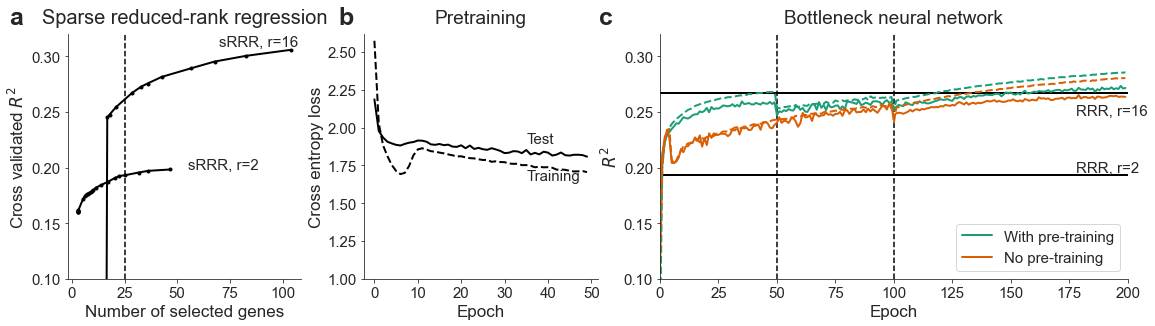

In [78]:
# All together in one plot
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    cr_16= np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]
    
    

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax1.set_ylim([0.1,0.32])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('Sparse reduced-rank regression', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=16', (70, np.max(cr_16)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (55, np.max(cr_2)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([1, ax2.get_ylim()[1]])
ax2.annotate('Training', (35, 1.65), fontsize=15)
ax2.annotate('Test', (35, 1.9), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,0,:], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,0,:], \
         c = '#1b9e77', linewidth=linewidth, label='With pre-training')
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0))[0,0,:], \
#          '--', c = '#d95f02', linewidth=linewidth)
# ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis=(0))[0,0,:], \
#          c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,0,:], \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,0,:], \
         c = '#d95f02', linewidth=linewidth, label='No pre-training')
ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=4)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=2)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.1,0.32])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=4)][0]-0.02), fontsize=15)
ax3.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=2)][0]+0.003), fontsize=15)
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='lower right', fontsize=15)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Allen_Lasso_training_curves.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Allen_Lasso_training_curves.png', bbox_inches='tight',
    pad_inches=0)

# Different # layers frozen

In [108]:
from bottleneck_networks import FreezeUnfreeze

In [135]:
# Settings
l2_params = np.logspace(-10, -10, num=1)
l1_params = np.array([1e-1])

act = 'elu'
folds = 5
seed = 42
lr=0.0001
epochs=50
bs=32
patience=epochs
pre_trained_weights=True
unfreeze = [False, True, True, True, True, True] # last 1 layer can be trained only first
prune=True

r2_before_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_before_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_after_unfreezing_ap_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0]))
r2_freeze_unfreeze_hist = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))
r2_freeze_unfreeze_hist_tr = np.zeros((folds, l1_params.shape[0], l2_params.shape[0], 4*epochs))

t = time.time()
np.random.seed(seed)
n = genes.shape[0]
ind = np.random.permutation(n)
X = genes[ind,:]
Y = ephys[ind,:]

nodes_list=[512,128,2,128,512]

# CV folds
for cvfold in range(folds):
    print('\nCVFOLD: ', cvfold)
    indtest  = np.arange(cvfold*int(n/folds), (cvfold+1)*int(n/folds))
    indtrain = np.setdiff1d(np.arange(n), indtest)
    x_train = np.copy(X[indtrain,:])
    y_train = np.copy(Y[indtrain,:])
    x_test = np.copy(X[indtest,:])
    y_test = np.copy(Y[indtest,:])

    # Mean centering (like sRRR)
    X_mean = np.mean(x_train, axis=0)
    x_train -= X_mean
    x_test -= X_mean
    Y_mean = np.mean(y_train, axis=0)
    y_train -= Y_mean
    y_test -= Y_mean
    
    input_dim = x_train.shape[1]
    output_dim = y_train.shape[1]
    
    for i, l2 in enumerate(l2_params):
        #print('Ridge penalty: ', l2)
        for j, l1 in enumerate(l1_params):
            #print('Lasso penalty: ', l1)
            
            pre_trained_weights_h5 = 'KerasSavedModels/Classification_last_weights_{}_{}_{}.h5'.format(cvfold, 2, i)
            input_dim = x_train.shape[1]
            output_dim = y_train.shape[1]
            BN_PreTrFreezeUnfreeze = FreezeUnfreeze(l1=l1, l2=l2, lr=lr, act=act, input_dim=input_dim, output_dim=output_dim, \
                                                       unfreeze = unfreeze, \
                                                       pre_trained_weights=pre_trained_weights, \
                                                       pre_trained_weights_h5=pre_trained_weights_h5, nodes_list=nodes_list)
            r2_before_unfreezing_train, r2_before_unfreezing_test, \
                r2_after_unfreezing_train, r2_after_unfreezing_test, \
                r2_after_unfreezing_train_ap, r2_after_unfreezing_test_ap, \
                train_hist, test_hist = BN_PreTrFreezeUnfreeze.train(x_train=x_train, y_train=y_train, \
                                                                    x_test=x_test, y_test=y_test, \
                                                                    epochs=epochs, bs=bs, patience=patience, \
                                                                    cvfold_id=cvfold, l1_id=j, l2_id=i, \
                                                                    prune=prune, geneNames=gene_names, \
                                                                    verbose=0)
            r2_before_unfreezing[cvfold, j, i] = r2_before_unfreezing_test
            r2_before_unfreezing_tr[cvfold, j, i] = r2_before_unfreezing_train
            r2_after_unfreezing[cvfold, j, i] = r2_after_unfreezing_test
            r2_after_unfreezing_tr[cvfold, j, i] = r2_after_unfreezing_train
            r2_after_unfreezing_ap[cvfold, j, i] = r2_after_unfreezing_test_ap
            r2_after_unfreezing_ap_tr[cvfold, j, i] = r2_after_unfreezing_train_ap
            r2_freeze_unfreeze_hist[cvfold, j, i] = test_hist
            r2_freeze_unfreeze_hist_tr[cvfold, j, i] = train_hist
            #print('Test R^2 score (before unfreezing): ', r2_before_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing): ', r2_after_unfreezing[cvfold, j, i])
            #print('Test R^2 score (after unfreezing and after pruning): ', r2_after_unfreezing_ap[cvfold, j, i])
            
t = time.time() - t
m,s = divmod(t, 60)
h,m = divmod(m, 60)
print('Time: {}h {:2.0f}m {:2.0f}s'.format(h,m,s))


CVFOLD:  0
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Kcnab1' 'Cntn4' 'Unc5d' 'Ak5' 'Galnt18' 'Nell1' 'Ptprt' 'Cplx3' 'Syt6'
 'Brinp3' 'A830018L16Rik' 'Gabrb2' 'Cdh7' 'Ndst3' 'Pcp4l1' 'Cacna2d3'
 'Zfp804a' 'Lrp1b' 'Sorcs1' 'Pvalb' 'Fxyd6' 'Mybpc1' 'Lamp5' 'Synpr' 'Vip']
[INFO] training network...
Train R^2 before unfreezing:  0.26550036668777466
Test R^2 before unfreezing:  0.278472363948822
Train R^2 after unfreezing:  0.26888471841812134
Test R^2 after unfreezing:  0.27625423669815063
Train R^2 after unfreezing and pruning:  0.2773968577384949
Test R^2 after unfreezing and pruning:  0.281141459941864

CVFOLD:  1
[INFO] training network...
[INFO] training network...
The 25 genes that make it:  ['Asic2' 'Alcam' 'Lrp1b' 'Npas3' 'Whrn' 'Lamp5' 'Tox' 'Tmem44' 'Srrm4'
 'Cntnap5c' 'Kcnab1' 'Sema3a' 'Zfp804a' 'Kctd8' 'Cacna1e' 'Nkain3' 'Ano4'
 'Npy' 'Pvalb' 'Nxph1' 'Zfp536' 'Mybpc1' 'Sst' 'Adarb2' 'Vip']
[INFO] training network...
Train R^2 before un

In [130]:
# with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_butlastlayer_unfreeze_lasso.pickle', 'wb') as f:
#     pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
#                  r2_after_unfreezing, r2_after_unfreezing_tr, \
#                  r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
#                  r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

In [136]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_1stlayeronly_unfreeze_lasso.pickle', 'wb') as f:
    pickle.dump([r2_before_unfreezing, r2_before_unfreezing_tr, \
                 r2_after_unfreezing, r2_after_unfreezing_tr, \
                 r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
                 r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr], f)

And loading all required files to plot

In [116]:
lambdas = np.arange(.5,3,.1)
alphas = np.array([1])

In [117]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank2_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)

In [118]:
with open('KerasSavedModels/gouwens_2020/sRRR_vs_Bottleneck_rank16_CV_lasso.pickle', 'rb') as f:
    r2_sRRR_rank16, r2_sRRR_relaxed_rank16, r2_sRRR_rank16_tr, r2_sRRR_relaxed_rank16_tr, \
                nonzero_rank16, corrs_rank16, corrs_relaxed_rank16 = pickle.load(f)

In [119]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_pre_tr_lasso.pickle', 'rb') as f:
    CE_loss, CE_loss_tr, pre_tr_hist, pre_tr_hist_tr = pickle.load(f)

In [120]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_straight_regr_lasso.pickle', 'rb') as f:
    r2_straight_regr, r2_straight_regr_tr, \
    r2_straight_regr_ap, r2_straight_regr_ap_tr, \
    r2_straight_regr_hist, r2_straight_regr_hist_tr = pickle.load(f)

In [121]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_straight_regr_lasso.pickle', 'rb') as f:
    r2_pretr_straight_regr, r2_pretr_straight_regr_tr, \
    r2_pretr_straight_regr_ap, r2_pretr_straight_regr_ap_tr, \
    r2_pretr_straight_regr_hist, r2_pretr_straight_regr_hist_tr = pickle.load(f)

In [131]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing, r2_before_unfreezing_tr, \
    r2_after_unfreezing, r2_after_unfreezing_tr, \
    r2_after_unfreezing_ap, r2_after_unfreezing_ap_tr, \
    r2_freeze_unfreeze_hist, r2_freeze_unfreeze_hist_tr = pickle.load(f)

In [132]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_butlastlayer_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing_butlast, r2_before_unfreezing_tr_butlast, \
    r2_after_unfreezing_butlast, r2_after_unfreezing_tr_butlast, \
    r2_after_unfreezing_ap_butlast, r2_after_unfreezing_ap_tr_butlast, \
    r2_freeze_unfreeze_hist_butlast, r2_freeze_unfreeze_hist_tr_butlast = pickle.load(f)

In [137]:
with open('KerasSavedModels/gouwens_2020/Bottleneck_r2_pre_tr_and_freeze_1stlayeronly_unfreeze_lasso.pickle', 'rb') as f:
    r2_before_unfreezing_1stonly, r2_before_unfreezing_tr_1stonly, \
    r2_after_unfreezing_1stonly, r2_after_unfreezing_tr_1stonly, \
    r2_after_unfreezing_ap_1stonly, r2_after_unfreezing_ap_tr_1stonly, \
    r2_freeze_unfreeze_hist_1stonly, r2_freeze_unfreeze_hist_tr_1stonly = pickle.load(f)

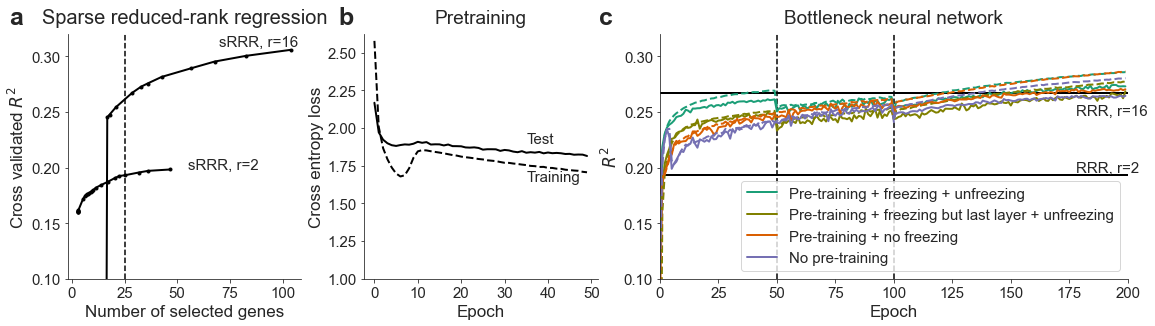

In [134]:
# All together in one plot
linewidth = 2
sns_styleset()

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    cr_16= np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]
    
    

# suppressing "mean of empty slice" warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_rank2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    r_rank2_r = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_rank16 = np.nanmean(nonzero_rank16, axis=0)[0, :]
    r_rank16_r = np.nanmean(r2_sRRR_relaxed_rank16, axis=0)[0, :]

# All together in one plot for the paper
fig = plt.figure(figsize=(19, 4.5))
widths = [1, 1, 2]
heights = [1]
spec = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                          height_ratios=heights)
ax1 = fig.add_subplot(spec[0, 0])
ax1.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax1.plot(n_16[1:], cr_16[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax1.set_ylim([0.1,0.32])
ax1.set_xlabel('Number of selected genes', fontsize = 17)
ax1.set_ylabel(r'Cross validated $R^2$', fontsize = 17)
ax1.set_title('Sparse reduced-rank regression', fontsize = 20, y=1.02)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.vlines(x=25, ymin=ax1.get_ylim()[0], ymax=ax1.get_ylim()[1], linestyles='dashed')
ax1.annotate('sRRR, r=16', (70, np.max(cr_16)+0.0003), fontsize=15)
ax1.annotate('sRRR, r=2', (55, np.max(cr_2)+0.0003), fontsize=15)


ax2 = fig.add_subplot(spec[0, 1])
ax2.plot(range(50), np.mean(pre_tr_hist_tr, axis=(0, 2))[2, :], \
         '--', c = 'k', linewidth=linewidth)
ax2.plot(range(50), np.mean(pre_tr_hist, axis=(0, 2))[2, :], \
         c = 'k', linewidth=linewidth)
ax2.set_title('Pretraining', fontsize = 19, y=1.02)
ax2.set_xlabel('Epoch', fontsize = 17)
ax2.set_ylabel('Cross entropy loss', fontsize = 17)
ax2.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='minor', labelsize=15)
ax2.set_ylim([1, ax2.get_ylim()[1]])
ax2.annotate('Training', (35, 1.65), fontsize=15)
ax2.annotate('Test', (35, 1.9), fontsize=15)
ax2.set_xticks(np.arange(0, 60, 10))

epochs_used=200
ax3 = fig.add_subplot(spec[0, 2])
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr, axis=(0))[2,1,:], \
         '--', c = '#1b9e77', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist, axis=(0))[2,1,:], \
         c = '#1b9e77', linewidth=linewidth, label='Pre-training + freezing + unfreezing')
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_butlast, axis=(0))[0,0,:], \
         '--', c = 'olive', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_butlast, axis=(0))[0,0,:], \
         c = 'olive', linewidth=linewidth, label='Pre-training + freezing but last layer + unfreezing')
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_tr_butlast, axis=(0))[0,0,:], \
         '--', c = 'black', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_freeze_unfreeze_hist_butlast, axis=(0))[0,0,:], \
         c = 'black', linewidth=linewidth, label='Pre-training + freezing 1st layer only + unfreezing')
ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist_tr, axis=(0))[0,1,:], \
         '--', c = '#d95f02', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_pretr_straight_regr_hist, axis=(0))[0,1,:], \
         c = '#d95f02', linewidth=linewidth, label='Pre-training + no freezing')
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist_tr, axis=(0))[0,1,:], \
         '--', c = '#7570b3', linewidth=linewidth)
ax3.plot(range(epochs_used), np.mean(r2_straight_regr_hist, axis=(0))[0,1,:], \
         c = '#7570b3', linewidth=linewidth, label='No pre-training')
ax3.hlines(r_rank16_r[np.isclose(n_rank16, 25, atol=4)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.hlines(r_rank2_r[np.isclose(n_rank2, 25, atol=2)], xmin = 0, xmax = epochs_used, \
            colors = np.array([0, 0, 0])/256, linewidth=linewidth)
ax3.set_ylim([0.1,0.32])
ax3.set_xlim([0,200])
ax3.set_xticks(np.arange(0, 225, 25))
ax3.annotate('RRR, r=16', (178, r_rank16_r[np.isclose(n_rank16, 25, atol=4)][0]-0.02), fontsize=15)
ax3.annotate('RRR, r=2', (178, r_rank2_r[np.isclose(n_rank2, 25, atol=2)][0]+0.003), fontsize=15)
ax3.set_title('Bottleneck neural network', fontsize = 19, y=1.02)
ax3.set_xlabel('Epoch', fontsize = 17)
ax3.set_ylabel(r'$R^2$', fontsize = 17)
ax3.tick_params(axis='both', which='major', labelsize=15)
ax3.tick_params(axis='both', which='minor', labelsize=15)
ax3.legend(loc='lower right', fontsize=13)
ax3.vlines(x=50, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')
ax3.vlines(x=100, ymin=ax3.get_ylim()[0], ymax=ax3.get_ylim()[1], linestyles='dashed')

plt.text(-0.25, 1.04, 'a', transform = ax1.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.11, 1.04, 'b', transform = ax2.transAxes, fontsize=25, fontweight='bold')
plt.text(-0.13, 1.04, 'c', transform = ax3.transAxes, fontsize=25, fontweight='bold')
sns.despine()

plt.savefig('figures/Allen_Lasso_training_curves_plusfreezebutlastlayer.pdf', bbox_inches='tight',
    pad_inches=0)
plt.savefig('figures/Allen_Lasso_training_curves_plusfreezebutlastlayer.png', bbox_inches='tight',
    pad_inches=0)